<center><span style="font-size:25px;font-weight:bold;color:black;">机器学习与数据挖掘实战</span></center>
$\quad$
<center><span style="font-size:20px;font-weight:bold;color:black;">课程项目展示</span></center>
$\quad$
<center>朱强强</center>
<center>17064001</center>
<center>应用统计学1701</center>

### 一、文本自动摘要(Automatic Text Summarization)介绍
文本摘要任务旨在从一篇或多篇相同主题的文本中抽取能够反映主题的精简压缩版本。     
分类：单文本摘要/多文本摘要，抽取式摘要/生成式摘要，面向查询的摘要/面向总结的摘要……       

### 二、TF-IDF
文本摘要很常见也是比较容易的方法就是词频统计。             
**计算词频**

$$
词频(TF)=某个词在文章中的出现次数
$$

考虑到文章有长短之分，为了便于不同文章的比较，进行“词频”标准化。

$$
词频(TF)=\dfrac{某个词在文章中的出现次数}{文章的总词数}      
$$
                           
**计算逆文档频率**          
我们需要一个重要性调整系数，衡量一个词是不是常见词。如果某个词比较少见，但是它在这篇文章中多次出现，那么它很可能就反映了这篇文章的特性，正是我们所需要的关键词。            
用统计学语言表达，就是在词频的基础上，要对每个词分配一个"重要性"权重。最常见的词（"的"、"是"、"在"）给予最小的权重，较常见的词给予较小的权重，较少见的词给予较大的权重。这个权重叫做"逆文档频率"（Inverse Document Frequency，缩写为IDF），它的大小与一个词的常见程度成反比。
          
$$
逆文档频率(IDF)=\log \dfrac{语料库的文档总数}{包含该词的文档数+1}
$$
      
如果一个词越常见，那么分母越大，逆文档频率越小越接近于0。分母加1视为了避免分母为0。
              
**计算TF-IDF**
       
$$
TF-IDF=词频(TF)\times 逆文档频率(IDF)
$$
     
TF-IDF与一个词在文档中的出现次数成正比，与该词在整个语言中的出现次数成反比。

### 三、余弦相似性
将两个句子用向量表示，两条向量之间形成一个夹角，如果夹角为0度，意味着方向相同、向量重合；如果夹角为90度，意味着形成直角，方向完全不相似；如果夹角为180度，意味着方向正好相反。因此，我们可以通过夹角的大小，来判断向量的相似程度。夹角越小，就代表越相似。                 
余弦定理：
$$
\cos \theta=\frac{a^{2}+b^{2}-c^{2}}{2 a b}
$$
        
余弦值越接近1，就表明夹角越接近0度，也就是两个向量越相似，这就是"余弦相似性"。      

### 四、词频统计算法

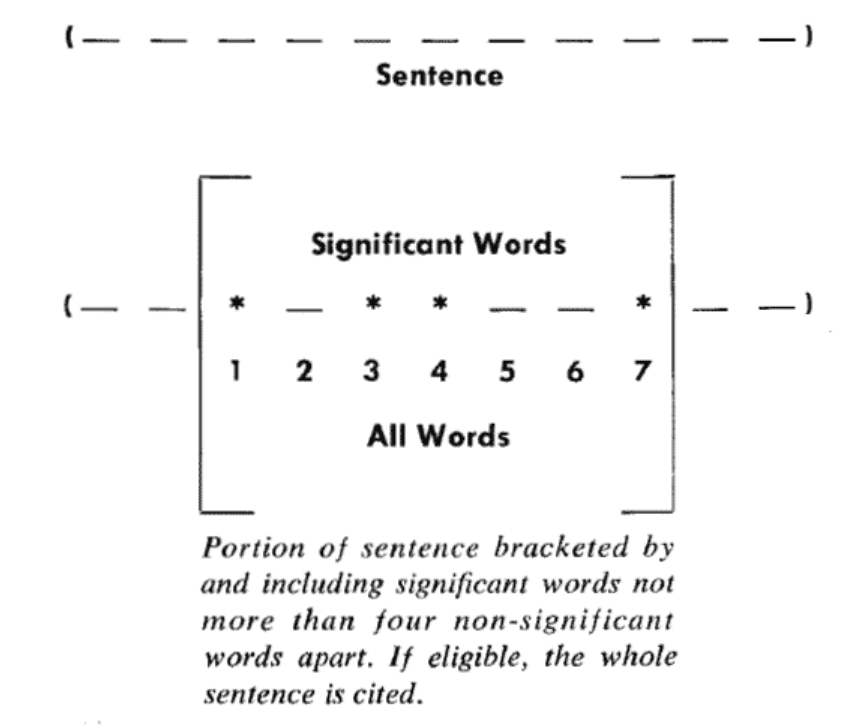

$$
簇的重要性=\dfrac{(包含的关键词数量)^2}{簇的长度}
$$

### 五、TextRank算法
源于PageRank算法

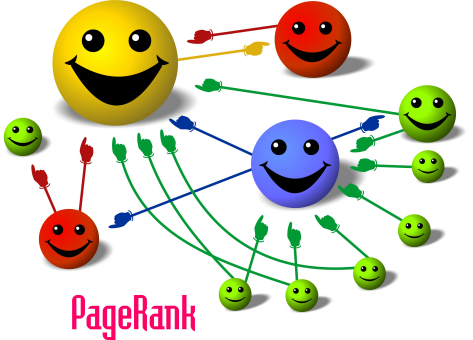
     
$$
S\left(V_{i}\right)=(1-d)+d \cdot \sum_{j \in I n\left(V_{i}\right)} \frac{1}{\left|O u t\left(V_{j}\right)\right|} S\left(V_{j}\right)
$$
             
TextRank 算法是一种基于图的用于文本自动摘要的排序算法，通过把文本分割成若干组成单元（句子），构建节点连接图，用句子之间的相似度作为边的权重，通过循环迭代计算句子的TextRank值，最后抽取排名高的句子组合成文本摘要。其优点是简洁高效，不需要事先对模型进行训练，属于一种无监督方法。

$$
TR\left(v_{i}\right)=\dfrac{1-d}{n} + d\left(\sum_{v_{j} \in In(v_i)} \dfrac{w_{ji}}{\sum_{v_{k} \in \operatorname{Out}(v_j)} w_{jk}} \operatorname{TR}(v_{j})\right), i=1,2, \ldots n
$$

$d$是阻尼系数，代表从某一句子指向其他任意句子的概率,一般设置为 0.85。           
$w_{ji}$为边的权重，也就是句子之间的相似度。           
$In(v_j)$是指向句子$v_j$的句子集合。          
$Out(v_j)$是句子$v_j$指出去的句子集合。
                  
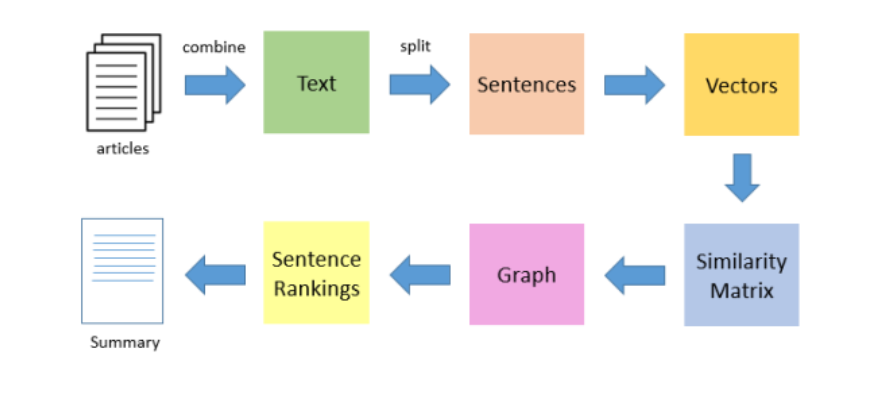

用TextRank做自动摘要的过程如下：
* 第一步是把所有文章整合成文本数据。
* 接下来把文本分割成单个句子。
* 为每个句子找到向量表示(word2vec, glove)。
* 计算句子向量间的相似性并存放在矩阵中。
* 将相似矩阵转换为以句子为节点、相似性得分为边的图结构，用于句子TextRank计算。
* 最后，选取TextRank得分最高的前n个句子构成最后的摘要。

In [ ]:
# -*- coding:utf-8 -*-

import nltk
import jieba
import codecs
import numpy as np
import networkx as nx
from sklearn.metrics.pairwise import cosine_similarity


# 文本预处理
def sent_tokenizer(texts):
    start = 0
    i = 0  # 每个字符的位置
    sentences = []
    punt_list = ".!?。！？；"
    for text in texts:
        if i < len(texts) - 1:
            if text in punt_list:
                sentences.append(texts[start:i + 1])  # 当前标点符号位置
                start = i + 1  # start标记到下一句的开头
                i += 1
            else:
                i += 1  # 若不是标点符号，则字符位置继续前移
        else:
            sentences.append(texts[start:])  # 处理文本末尾没有标点符号的情况
            break
    return sentences


# 停用词
def load_stop_words_list(path):
    stop_list = [
        line.strip()
        for line in codecs.open(path, 'r', encoding='utf8').readlines()
    ]
    stop_words = {}.fromkeys(stop_list)
    return stop_words


# 摘要
def summarize(text):
    stopwords = load_stop_words_list("stopwords.txt")
    sentences = sent_tokenizer(text)
    words = [
        w for sentence in sentences for w in jieba.cut(sentence)
        if w not in stopwords if len(w) > 1 and w != '\t'
    ]
    word_frequency = nltk.FreqDist(words)
    top_words = [
        w[0] for w in sorted(
            word_frequency.items(), key=lambda d: d[1], reverse=True)
    ][:n]
    scored_sentences = _score_sentences(sentences, top_words)
    # 利用均值和标准差过滤非重要句子
    avg = np.mean([s[1] for s in scored_sentences])  
    std = np.std([s[1] for s in scored_sentences]) 
    mean_scored = [(sent_idx, score) for (sent_idx, score) in scored_sentences
                   if score > (avg + 1.5 * std)]
    top_n_scored = sorted(scored_sentences,
                          key=lambda s: s[1])[-num_top_sentence:]
    top_n_scored = sorted(top_n_scored, key=lambda s: s[0])
    return dict(
        top_n_summary=[sentences[idx] for (idx, score) in top_n_scored],
        mean_scored_summary=[sentences[idx] for (idx, score) in mean_scored])


# 句子得分
def _score_sentences(sentences, top_words):
    scores = []
    sentence_idx = -1
    for s in [list(jieba.cut(s)) for s in sentences]:
        sentence_idx += 1
        word_idx = []
        for index in range(len(s)):
            if s[index] in top_words:
                word_idx.append(index)
            else:
                pass
        word_idx.sort()
        if len(word_idx) == 0:
            continue
        # 对于两个连续的单词，利用单词位置索引，通过距离阈值计算簇
        clusters = []
        cluster = [word_idx[0]]
        i = 1
        while i < len(word_idx):
            if word_idx[i] - word_idx[i - 1] < cluster_distance:
                cluster.append(word_idx[i])
            else:
                clusters.append(cluster[:])
                cluster = [word_idx[i]]
            i += 1
        clusters.append(cluster)
        # 对每个簇打分，每个簇类的最大分数是对句子的打分
        max_cluster_score = 0
        for c in clusters:
            key_words = len(c)
            total_words = c[-1] - c[0] + 1
            score = key_words * key_words / total_words
            if score > max_cluster_score:
                max_cluster_score = score
        scores.append((sentence_idx, max_cluster_score))
    return scores


# TextRank算法
def text_rank_summarize(text):
    stopwords = load_stop_words_list('E:/Python Files/stopwords/中文停用词表.txt')
    sentences = sent_tokenizer(text)
    words_list = []
    for sentence in sentences:
        word_list = [
            w for w in jieba.cut(sentence) if w not in stopwords
            if len(w) > 1 and w != '\t'
        ]
        words_list.append(word_list)

    # 加载word2vec词向量
    word_embeddings = {}
    with codecs.open("sgns.renmin.char", encoding='utf-8') as f:
        for line in f:
            # 把第一行的内容去掉
            if '355996 300\n' not in line:
                values = line.split()
                word = values[0]
                embedding = np.asarray(values[1:], dtype='float32')
                word_embeddings[word] = embedding
        f.close()

    # 得到句子的向量表示
    sentence_vectors = []
    for word_list in words_list:
        if len(word_list) != 0:
            # 如果句子中的词语不在字典中，那就把embedding设为300维元素为0的向量。
            # 得到句子中全部词的词向量后，求平均值，得到句子的向量表示
            v = sum(
                [word_embeddings.get(w, np.zeros([
                    300,
                ])) for w in word_list]) / (len(word_list))
        else:
            # 如果句子为[]，那么就向量表示为300维元素为0个向量。
            v = np.zeros([
                300,
            ])
        sentence_vectors.append(v)

    # 计算句子之间的余弦相似度，构成相似度矩阵
    sim_mat = np.ones([len(words_list), len(words_list)])
    for i in range(len(words_list)):
        for j in range(len(words_list)):
            if i != j:
                sim_mat[i][j] = cosine_similarity(
                    sentence_vectors[i].reshape(1, 300),
                    sentence_vectors[j].reshape(1, 300))[0, 0]

    # 利用句子相似度矩阵构建图结构，句子为节点，句子相似度为转移概率
    nx_graph = nx.from_numpy_array(sim_mat)

    # 得到所有句子的TextRank值
    scores = nx.pagerank(nx_graph)

    # 根据TextRank值对句子进行排序
    ranked_sentences = sorted(
        ((scores[i], s) for i, s in enumerate(sentences)), reverse=True)

    result = []
    for i in range(num_top_sentence):
        result.append(ranked_sentences[i][1])

    return result


# 读取文本文件
def read_text(path):
    with codecs.open(path, "r", encoding="utf-8") as f:
        text = f.read()
    return text


if __name__ == '__main__':
    n = 30  # 关键词数量
    cluster_distance = 5  # 单词间的距离
    num_top_sentence = 5  # 返回句子的数量
    text = read_text("text.txt")
    algorithm1 = summarize(text)
    algorithm2 = text_rank_summarize(text)
    print('--------------top_n_summary----------------')
    for sent in algorithm1['top_n_summary']:
        print(sent)
    print('-----------mean_scored_summary-------------')
    for sent in algorithm1['mean_scored_summary']:
        print(sent)
    print('----------------TextRank-------------------')
    for sent in algorithm2:
        print(sent)
